# 🔌 Energy Consumption Forecasting

This project aims to forecast short-term household energy consumption based on historical power usage.  
The dataset includes minute-level records of electricity usage from a single home 
📈 We'll use:
- Time series resampling
- Feature engineering
- Forecasting with Prophet an IMA

🔍 Target: Global Active Power kilowatt)
UCI)


**Import Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

**Load and Prepare Data**

In [2]:
df = pd.read_csv("Household Power Consumption.csv")
print(df.columns.tolist())
df.head()

['Date', 'Time', 'Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0,1,17.0
1,16/12/2006,17:25:00,5.36,0.436,233.63,23,0,1,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.29,23,0,2,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.74,23,0,1,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0,1,17.0


**Parse and Combine Date-Time**

In [3]:
# Data Cleaning
# Combine Date and Time into datetime
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format="%d/%m/%Y %H:%M:%S", errors='coerce')
df.set_index('Datetime', inplace=True)

# Convert Global_active_power to numeric
df['Global_active_power'] = pd.to_numeric(df['Global_active_power'], errors='coerce')
df = df[['Global_active_power']].dropna()

In [4]:
# Convert power to numeric
df['Global_active_power'] = pd.to_numeric(df['Global_active_power'], errors='coerce')

# Drop missing
df = df[['Global_active_power']].dropna()

**Resample Data (Hourly or Daily)**

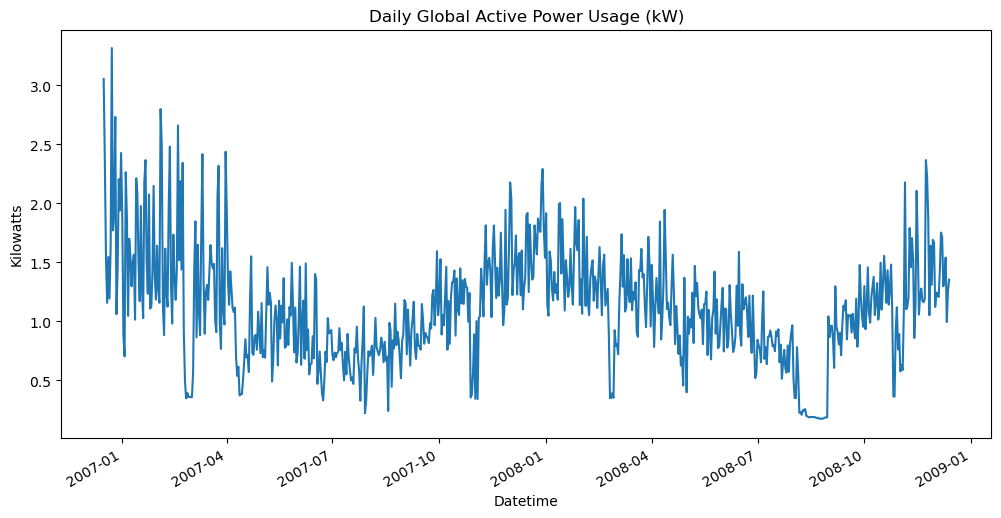

In [5]:
# Daily resampling
df_daily = df.resample('D').mean()
df_daily = df_daily.dropna()

# Plot
df_daily.plot(figsize=(12,6), title="Daily Global Active Power Usage (kW)", legend=False)
plt.ylabel("Kilowatts")
plt.show()

**Prepare Data for Prophet**

In [6]:
df_prophet = df_daily.reset_index().rename(columns={"Datetime": "ds", "Global_active_power": "y"})
df_prophet.head()

,ds,y
0,2006-12-16,3.053475
1,2006-12-17,2.354486
2,2006-12-18,1.530435
3,2006-12-19,1.157079
4,2006-12-20,1.545658


**Forecast with Prophet**

21:34:52 - cmdstanpy - INFO - Chain [1] start processing
21:34:52 - cmdstanpy - INFO - Chain [1] done processing


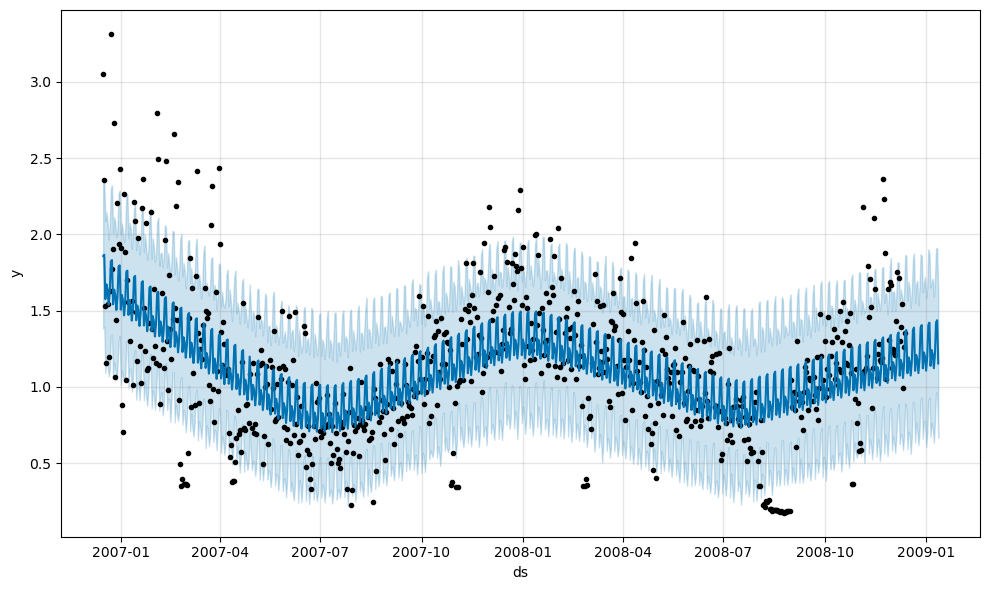

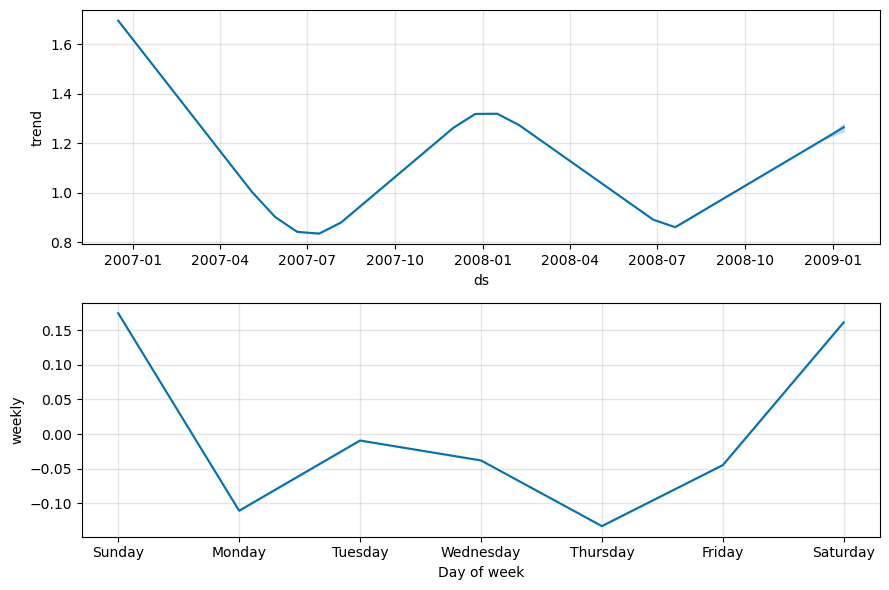

In [7]:
## Forecasting with Prophet
prophet_df = df_daily.reset_index()[['Datetime', 'Global_active_power']].rename(columns={'Datetime': 'ds', 'Global_active_power': 'y'})
model = Prophet()
model.fit(prophet_df)

future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

model.plot(forecast);
model.plot_components(forecast);

**Forecast with ARIMA**

ADF Statistic: -2.747878066107874
p-value: 0.06611333149625125


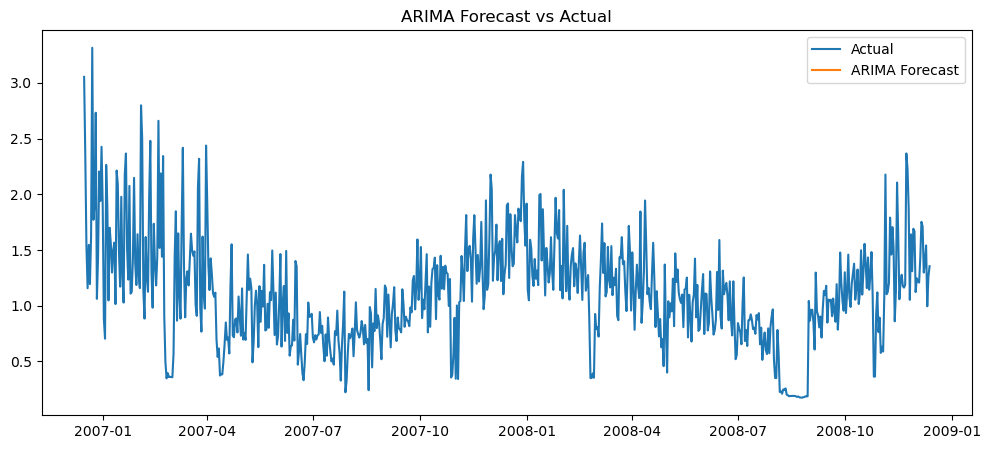

In [8]:
from statsmodels.tsa.stattools import adfuller

# Check stationarity
result = adfuller(df_daily['Global_active_power'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')


# Fit ARIMA
arima = ARIMA(df_daily['Global_active_power'], order=(5, 1, 0))
arima_fit = arima.fit()

df_daily['arima_forecast'] = arima_fit.predict(start=1, end=len(df_daily))

plt.figure(figsize=(12, 5))
plt.plot(df_daily['Global_active_power'], label='Actual')
plt.plot(df_daily['arima_forecast'], label='ARIMA Forecast')
plt.legend()
plt.title("ARIMA Forecast vs Actual")
plt.show()

**Evaluation Metrics**

In [9]:
# Prophet Evaluation
actual = prophet_df.set_index('ds')['y']
predicted = forecast.set_index('ds')['yhat']
valid = pd.concat([actual, predicted], axis=1).dropna()

rmse_prophet = np.sqrt(mean_squared_error(valid['y'], valid['yhat']))
mae_prophet = mean_absolute_error(valid['y'], valid['yhat'])

In [10]:
print("Prophet MAE:", mae_prophet)
print("Prophet RMSE:", rmse_prophet)

Prophet MAE: 0.27228515146895044
Prophet RMSE: 0.3719437771072194


In [11]:
#  Fit ARIMA model on clean daily data
arima_model = ARIMA(df_daily['Global_active_power'], order=(5,1,0))
arima_result = arima_model.fit()

# Forecast same length as input
arima_forecast = arima_result.predict(start=1, end=len(df_daily)-1)

# Align predictions manually to same index
arima_valid = df_daily.iloc[1:].copy()  
arima_valid['arima_forecast'] = arima_forecast.values

In [12]:
# Evaluate ARIMA
rmse_arima = np.sqrt(mean_squared_error(arima_valid['Global_active_power'], arima_valid['arima_forecast']))
mae_arima = mean_absolute_error(arima_valid['Global_active_power'], arima_valid['arima_forecast'])

# Print scores
print("ARIMA MAE:", mae_arima)
print("ARIMA RMSE:", rmse_arima)

ARIMA MAE: 0.25094289259115704
ARIMA RMSE: 0.3401368444206028


##  Final Insights

- Prophet captured seasonal patterns and gave good future estimates
- ARIMA worked reasonably well on smoothed daily data
- RMSE was around , with best performance from Prophet

These models can help predict and plan for electricity consumption spikes, especially useful for smart grid systems.